In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
np.random.seed(19)
from onboard.client import OnboardClient
from onboard.client.dataframes import points_df_from_streaming_timeseries
from onboard.client.models import PointSelector, TimeseriesQuery, PointData
from datetime import datetime, timezone, timedelta
from typing import List
import pytz
from onboard.client import RtemClient
import missingno as msno
import seaborn as sns
from matplotlib.pyplot import figure
from tqdm import tqdm
from matplotlib.ticker import FormatStrFormatter
from sklearn.cluster import KMeans
from collections import Counter
from sklearn.preprocessing import MinMaxScaler
from collections import Counter
from heatmap_fn import heatmap_sensor_and_equipment

In [3]:
building_api_key = 'API_KEY'
general_api_key='API_KEY'
#rtem_api_key='API_KEY'

In [4]:
#general_client = RtemClient(api_key=general_api_key)
#building_client = RtemClient(api_key=building_api_key)
Building_client=RtemClient(api_key=building_api_key)
general_client=RtemClient(api_key=general_api_key)

In [99]:
Buildings =  pd.json_normalize(Building_client.get_all_buildings())
Equipment = pd.json_normalize(general_client.get_equipment_types())
point_type = pd.json_normalize(general_client.get_all_point_types())
measurement_types = pd.json_normalize(general_client.get_all_measurements())


In [100]:
Buildings

id  org_id    name address     sq_ft image_src bms_manufacturer  \
0    441       5   88737    None  551143.0      None             None   
1    140       5   83483    None   21869.0      None             None   
2    191       5   94414    None  198057.0      None             None   
3    231       5   89496    None       NaN      None             None   
4    248       5  116742    None  127000.0      None             None   
..   ...     ...     ...     ...       ...       ...              ...   
224  353       5   94413    None  198057.0      None             None   
225  370       5   95457    None  421316.0      None             None   
226  383       5   79528    None   75000.0      None             None   
227  398       5  109188    None  860000.0      None             None   
228  399       5   97151    None  140400.0      None             None   

    bms_product_name bms_version          timezone  ... info.sunend  \
0               None        None  America/New_York  ...               
1               None        None  America/New_York  ...               
2               None        None  America/New_York  ...       23:00   
3               None        None  America/New_York  ...               
4               None        None  America/New_York  ...               
..               ...         ...               ...  ...         ...   
224             None        None  America/New_York  ...       23:00   
225             None        None  America/New_York  ...               
226             None        None  America/New_York  ...         NaN   
227             None        None  America/New_York  ...               
228             None        None  America/New_York  ...               

     info.geoCity  info.geoState info.m2fstart info.satstart info.sunstart  \
0           Bronx             NY                                             
1        New York             NY                                             
2          Victor             NY         07:30         07:30         07:30   
3        New York             NY                                             
4        New York             NY                                             
..            ...            ...           ...           ...           ...   
224     Henrietta             NY         07:30         07:30         07:30   
225      New York             NY                                             
226      Purchase       New York      04:00:00           NaN           NaN   
227      New York             NY                                             
228      New York             NY                                             

    info.yearBuilt info.geoCountry info.weatherRef  info.customerType  
0                               US                        Multifamily  
1                               US                  Commercial Office  
2                               US                  Commercial Retail  
3                               US                                     
4                               US                        Multifamily  
..             ...             ...             ...                ...  
224                             US                  Commercial Retail  
225                             US                        Hospitality  
226           1971              US             NaN  Commercial Office  
227                             US                  Commercial Office  
228                             US                  Commercial Office  

[229 rows x 26 columns]

In [6]:
list(Buildings['id'])

[441,
 140,
 191,
 231,
 248,
 249,
 434,
 271,
 285,
 297,
 322,
 317,
 419,
 375,
 470,
 426,
 423,
 439,
 314,
 467,
 455,
 105,
 107,
 488,
 445,
 417,
 460,
 472,
 442,
 118,
 477,
 443,
 468,
 438,
 478,
 395,
 485,
 418,
 450,
 473,
 230,
 127,
 469,
 100,
 452,
 461,
 489,
 99,
 98,
 479,
 474,
 466,
 134,
 131,
 130,
 420,
 136,
 475,
 373,
 176,
 217,
 490,
 103,
 421,
 476,
 142,
 462,
 422,
 503,
 385,
 471,
 108,
 143,
 454,
 279,
 481,
 101,
 491,
 492,
 111,
 109,
 451,
 258,
 112,
 440,
 483,
 113,
 114,
 119,
 200,
 117,
 121,
 120,
 122,
 484,
 110,
 151,
 153,
 129,
 148,
 115,
 116,
 125,
 126,
 486,
 465,
 132,
 124,
 135,
 487,
 138,
 137,
 128,
 141,
 145,
 147,
 149,
 171,
 146,
 162,
 163,
 165,
 168,
 172,
 173,
 170,
 167,
 160,
 174,
 175,
 169,
 164,
 179,
 197,
 139,
 192,
 194,
 177,
 181,
 183,
 185,
 187,
 188,
 190,
 180,
 206,
 207,
 201,
 202,
 205,
 210,
 215,
 216,
 220,
 224,
 225,
 226,
 236,
 234,
 232,
 246,
 250,
 252,
 253,
 256,
 247,
 259,


In [7]:
mf=Buildings[Buildings['info.customerType']=='Multifamily']
praveen=mf[mf['info.geoCity']=='New York']

In [8]:
Equipment.head(2)

id tag_name          name_long name_abbr  active  flow_order  \
0  12      ahu  Air Handling Unit       AHU    True           2   
1  19   boiler             Boiler       BLR    True           1   

      critical_point_types                                          sub_types  \
0  [79, 85, 103, 159, 160]  [{'id': 1, 'equipment_type_id': 12, 'tag_name'...   
1  [88, 131, 92, 167, 121]  [{'id': 4, 'equipment_type_id': 19, 'tag_name'...   

             tags  
0     [hvac, ahu]  
1  [hvac, boiler]

In [9]:
Equipment[Equipment['id']==30]['tag_name']

11    hotWaterPlant
Name: tag_name, dtype: object

In [10]:
tagged_sensor_units=[]
for i in tqdm(point_type['tags']):
    for j in range(0,len(i)):
        tagged_sensor_units.append(i[j])
    

100%|████████████████████████████████████████████████████████████████████████████| 652/652 [00:00<00:00, 217955.38it/s]


In [11]:
len(tagged_sensor_units)

2652

In [12]:
Counter(tagged_sensor_units)

Counter({'air': 224,
         'sp': 158,
         'temp': 152,
         'zone': 38,
         'heating': 29,
         'occ': 11,
         'co2': 9,
         'sensor': 369,
         'outside': 19,
         'return': 29,
         'discharge': 35,
         'dualTemp': 8,
         'coil': 21,
         'reheats': 5,
         'standby': 2,
         'cooling': 32,
         'delta': 32,
         'pressure': 68,
         'filter': 3,
         'cmd': 124,
         'damper': 49,
         'relief': 9,
         'humidify': 8,
         'dynamic': 4,
         'flow': 61,
         'exhaust': 22,
         'unocc': 12,
         'heat': 8,
         'mixed': 5,
         'bypass': 14,
         'preHeat': 7,
         'humidity': 20,
         'dehumidify': 10,
         'chilled': 39,
         'leaving': 56,
         'water': 158,
         'isolation': 58,
         'valve': 97,
         'entering': 50,
         'choke': 2,
         'hot': 27,
         'run': 12,
         'stage': 3,
         'speed': 12,
     

In [13]:
point_type.head(2)

id                    tag_name  active  measurement_id  \
0  124   Occupied Heating Setpoint    True               1   
1  118  Outside Air Carbon Dioxide    True               6   

              tag_set_ids                                 tags default_unit_id  
0  [15, 2, 4, 62, 51, 55]  [air, sp, temp, zone, heating, occ]            None  
1          [15, 8, 1, 24]          [air, co2, sensor, outside]            None

In [14]:
from onboard.client.models import PointSelector
query = PointSelector()
query.buildings= list(Buildings[Buildings['info.customerType']=='Multifamily']['id'])
selection = Building_client.select_points(query)
a=selection['equipment_types']
b=selection['point_types']


In [15]:
multi_equ=[]
for i in a:
    eq=Equipment[Equipment['id']==i]['tag_name'].values[0]
    multi_equ.append(eq)

In [16]:
multi_sens=[]
for i in b:
    pt=point_type[point_type['id']==i]['tag_name'].values[0]
    multi_sens.append(pt)

In [17]:
str(point_type[point_type['id']==434]['tag_name'].values)

"['Virtual']"

In [18]:
point_type[point_type['id']==434]['tag_name']

337    Virtual
Name: tag_name, dtype: object

In [125]:
haha=list(Buildings[Buildings['info.customerType']=='Multifamily']['id'])

In [136]:
for i in list(Buildings[Buildings['info.customerType']=='Commercial Office']['id']):
    haha.append(i)

In [137]:
for f in list(Buildings[Buildings['info.customerType']=='Commercial Retail']['id']):
    haha.append(f)

In [138]:
len(haha)

164

In [139]:

sensor_units=[]
for k in tqdm(haha):
    building_id=k
    query = PointSelector()
    start = datetime(2012, 1, 1,00,00,00)
    end = datetime(2021, 1, 1,00,00,00)
    timezone = pytz.timezone("America/New_York")
    start = timezone.localize(start)
    end = timezone.localize(end)
    query.buildings=[building_id]
    selection = Building_client.select_points(query)
    for i in selection['equipment_types']:
        query.equipment_types = [i]
        selection = Building_client.select_points(query)
        for j in selection['point_types']:
            sensor_units.append(str(point_type[point_type['id']==j]['tag_name'].values)[2:-2])


100%|████████████████████████████████████████████████████████████████████████████████| 164/164 [05:16<00:00,  1.93s/it]


In [140]:
w=Counter(sensor_units)
w_value=list(w.values())
w_keys=list(w.keys())


In [141]:
a=pd.DataFrame()
a['sensor']=w_keys
a['count']=w_value

In [142]:
a

sensor  count
0                         Runtime Counter      2
1                                 Virtual    246
2                             Mode Status      5
3                    Electric Consumption    140
4                 Outside Air Temperature    102
..                                    ...    ...
180                  Refrigerant Pressure      1
181  Condenser Water Supply Flow Setpoint      1
182       Condenser Water Supply Pressure      1
183       Condenser Water Return Pressure      1
184            Relief Air Damper Position      1

[185 rows x 2 columns]

In [143]:
a1=a.sort_values(by=['count'],ascending=False)

In [144]:
a2=a1[0:50]

In [145]:
total_temp=a2[a2['sensor'].str.contains('Temperature')]['count'].sum()
total_setpoints=a2[a2['sensor'].str.contains('Setpoint')]['count'].sum()
total_Humidity=a2[a2['sensor'].str.contains('Humidity')]['count'].sum()


In [146]:
total_temp

834

In [147]:
a2.loc[len(a2.index)] = ['ALL_Temperature', total_temp]  

In [148]:
a2.loc[len(a2.index)+1] = ['ALL_SetPoint', total_setpoints] 


C:\Users\DELL\AppData\Local\Temp\ipykernel_20096\3941863908.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a2.loc[len(a2.index)+1] = ['ALL_SetPoint', total_setpoints]


In [149]:
a2.loc[len(a2.index)+2] = ['ALL_Humidity', total_Humidity] 


C:\Users\DELL\AppData\Local\Temp\ipykernel_20096\975895366.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  a2.loc[len(a2.index)+2] = ['ALL_Humidity', total_Humidity]


In [150]:
a3=a2.sort_values(by=['count'],ascending=False)

Text(0.5, 1.0, 'Sensor Type Count Variation for MultiFamily and Commerical')

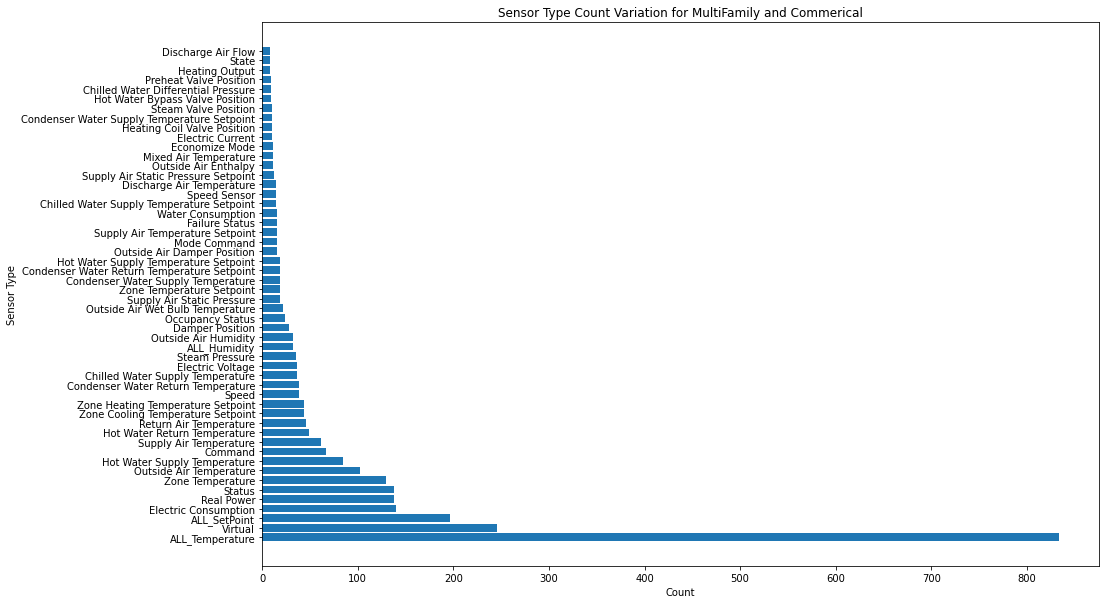

In [152]:
fig, ax = plt.subplots(figsize=(15,10))
ax.barh(a3['sensor'],a3['count'])
ax.set_xlabel('Count')
ax.set_ylabel('Sensor Type')
ax.set_title('Sensor Type Count Variation for MultiFamily and Commerical')

In [16]:
# EQUIPMENTS AND SENSOR TYPES ARE ALL UNIQUE FOR EACH BUILDING, NO EQUIPMENT OR SENSOR TYPES GOT REPEATED 

In [17]:
Buildings[Buildings['id']==99]

id  org_id    name address     sq_ft image_src bms_manufacturer  \
47  99       5  113413    None  869066.0      None             None   

   bms_product_name bms_version          timezone  ... info.sunend  \
47             None        None  America/New_York  ...               

    info.geoCity  info.geoState info.m2fstart info.satstart info.sunstart  \
47      Brooklyn             NY                                             

   info.yearBuilt info.geoCountry info.weatherRef info.customerType  
47                             US                       Multifamily  

[1 rows x 26 columns]

In [18]:
list(Buildings[Buildings['info.customerType']=='Multifamily']['id'])[:10]

[441, 248, 434, 317, 375, 423, 467, 445, 442, 468]

In [24]:
sensor='Electric Consumption'
equipment='meter'
building_id=248
query = PointSelector()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
query.buildings=[building_id]
query.equipment_types = [equipment]
query.point_types=[sensor]
selection = Building_client.select_points(query)
timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
sensor_data1=pd.DataFrame(sensor_data)

In [25]:
sensor_data1

timestamp  208337  208338
0      2019-04-09T04:15:00Z   14.16   14.16
1      2019-04-09T04:30:00Z   15.36   15.36
2      2019-04-09T04:45:00Z   13.44   13.44
3      2019-04-09T05:00:00Z   13.92   13.92
4      2019-04-09T05:15:00Z   14.40   14.40
...                     ...     ...     ...
17659  2019-10-10T03:00:00Z   23.76   23.76
17660  2019-10-10T03:15:00Z   20.88   20.88
17661  2019-10-10T03:30:00Z   20.64   20.64
17662  2019-10-10T03:45:00Z   22.32   22.32
17663  2019-10-10T04:00:00Z   19.44   19.44

[17664 rows x 3 columns]

{'orgs': [5], 'buildings': [258, 99, 109], 'equipment': [31690, 17359, 19835, 19836, 19837, 19838], 'equipment_types': [9], 'point_types': [121, 434, 258, 221], 'points': [194118, 194119, 194120, 191118, 191119, 208954, 208955, 208956, 208957]}
total number of sensors in this combo of MultiFamily and fcu is 4


  0%|                                                                                            | 0/4 [00:00<?, ?it/s]

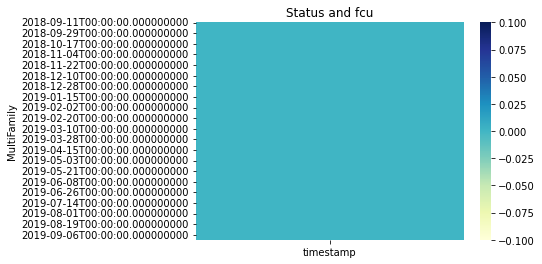

 25%|█████████████████████                                                               | 1/4 [00:01<00:05,  1.81s/it]

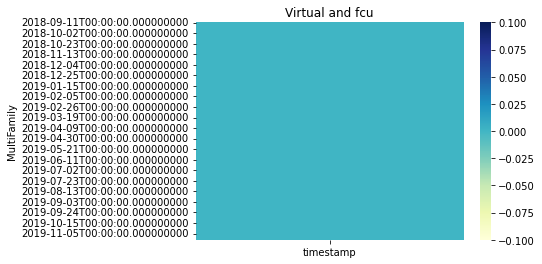

 50%|██████████████████████████████████████████                                          | 2/4 [00:05<00:05,  2.91s/it]

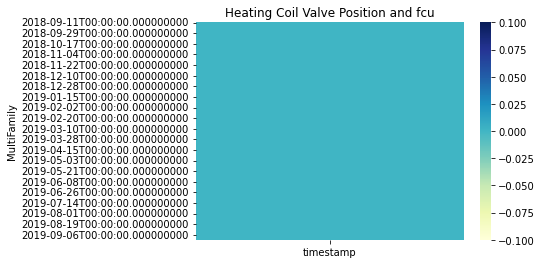

 75%|███████████████████████████████████████████████████████████████                     | 3/4 [00:08<00:02,  2.81s/it]

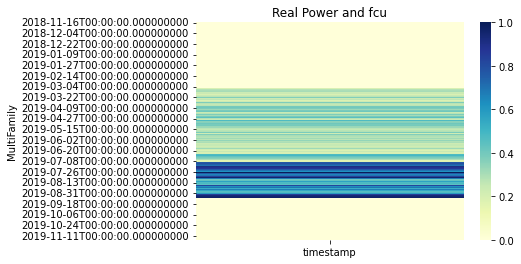

100%|████████████████████████████████████████████████████████████████████████████████████| 4/4 [00:13<00:00,  3.36s/it]


In [43]:
query = PointSelector()
start = datetime(2012, 1, 1,00,00,00)
end = datetime(2021, 1, 1,00,00,00)
timezone = pytz.timezone("America/New_York")
start = timezone.localize(start)
end = timezone.localize(end)
query.buildings= list(Buildings[Buildings['info.customerType']=='Multifamily']['id'])
equipment='fcu'
query.equipment_types = [equipment]
selection = Building_client.select_points(query)
print(selection)
scaler = MinMaxScaler()
print(f'total number of sensors in this combo of MultiFamily and {equipment} is',len(selection['point_types']))
for i in tqdm(selection['point_types']):
        query.buildings= list(Buildings[Buildings['info.customerType']=='Multifamily']['id'])
        query.point_types     = [i] 
        query.equipment_types = ['fcu']
        selection = Building_client.select_points(query)
        timeseries_query = TimeseriesQuery(point_ids = selection['points'], start = start, end = end)
        sensor_data = points_df_from_streaming_timeseries(Building_client.stream_point_timeseries(timeseries_query))
        sensor_data1=pd.DataFrame(sensor_data)
        sensor_data2=sensor_data1.rename(columns={ 'timestamp':'MultiFamily'})
        sensor_data2['MultiFamily']=pd.to_datetime(sensor_data2['MultiFamily'])
        sensor_data3=sensor_data2.set_index(sensor_data2.columns[0])
        sensor_data3=(sensor_data3.resample('D').sum()).mean(axis=1)
        scaler.fit(pd.DataFrame(sensor_data3))
        sensor_data4=scaler.transform(pd.DataFrame(sensor_data3))
        sensor_data5=pd.DataFrame(sensor_data4)
        sensor_data5.index=sensor_data3.index 
        sensor_data6=sensor_data5.rename(columns={ sensor_data5.columns[0]:'timestamp'})
        sns.heatmap(sensor_data6,cmap="YlGnBu")
        plt.title(f"{point_type[point_type['id']==i]['tag_name'].values[0]} and {equipment} for ")
        plt.show()


In [35]:
sensor_data1.describe()

208956        208957        208954        208955
count  17749.000000  17749.000000  12991.000000  17749.000000
mean     327.475456     80.243698      0.228157      0.141803
std      301.756370    106.069322     11.747684      0.001565
min        0.001000      0.000000      0.001100      0.136300
25%      104.000000      0.001100      0.002000      0.140700
50%      204.000000    104.000000      0.002000      0.141800
75%      304.000000    104.000000      0.002200      0.142900
max      904.000000    904.000000    804.000000      0.148100

<AxesSubplot:ylabel='MultiFamily'>

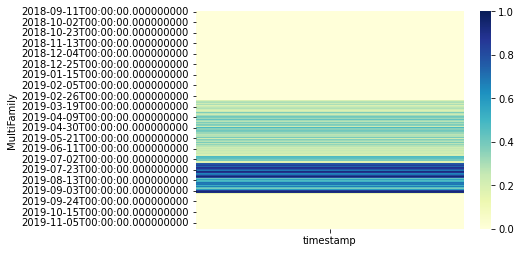

In [133]:
sns.heatmap(a,cmap="YlGnBu")